In [26]:
# Python 3.10.11

import numpy as np # v. 1.22.1
from matplotlib import pyplot as plt # v. 3.7.5
import os
import pandas as pd # v. 1.5.3
import seaborn as sns # v. 0.12.2
import pykrev as pk # v. 1.2.4
import datetime

from corems.transient.input.brukerSolarix import ReadBrukerSolarix # v. 1.6.0
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas

The directory tree is organised as follows:

<img src="dir_tree_&_workflow.png" />

For the code to work, please modify the variable ```general_dir``` so as to direct the code towards the desired folder.

In [27]:
# Specify the folder where the MS data is, with the directory tree shown above.
general_dir = '../../MS_data/dummy_31-10-2024'

# Important folders and files, without the general_dir prefix
spectra_folder = 'ms_files'
run_order = 'run_order.csv'
ref_file_location = 'Hawkes_neg.ref'
param_file = "parameters.txt"

# Change truth value if you do/don't want them
filter_noise = 1
calibration = 0
logs = 1
remove_blanks = 1
save = 1

In [28]:
# Change directory to the general_dir
os.chdir(general_dir)

In [29]:
# Declare folder db where the molformulas.sqlite file will be created and stored.
db = f'db'
if not os.path.exists(db): os.mkdir(db)

In [30]:
def read_params(file_name:str,sep='\n---\n',comment='#'):
    '''
    You can use the read_params function to read in the parameters needed to process MS spectra of organic matter.
    The parameter file takes the following shape:

    ELEMENTAL PARAMETERS:
        C: 1, 100
        H: 1, 200
        O: 0, 26
    ---
    DBE: 0, 50
    ---
    PPM ERROR: 1
    ---
    MODE: -
    ---
    NOISE THRESHOLD STD: 3
    ---
    CALIB PPM THRESHOLD:
    31/10/2024: -0.1, 2.7
    02/11/2024: 0.5, 2
    ---
    O/C: 0, 1.2
    ---
    H/C: 0.3, 2.5
    ---

    Where "\\n---\\n" is the default separator.
    You can comment out sections by adding "#" at the beginning of the line, though you can also change this by setting the variable comment to something else.
    As such, make sure that file_name is a string of literals

    '''

    assert type(file_name) == str, 'The variable file_name must be a string of literals'
    assert type(sep) == str, 'The variable sep must be a string of literals'
    assert type(comment) == str, 'The variable comment must be a string of literals'

    def is_not_comment(str:str,comment:str):
        return not (str.startswith(comment) or str.startswith('\t'+comment))

    param_file = open(file_name, "r").read().split(sep)


    elem_dic = {}
    elem_ratios_dic = {}

    for p in param_file:
        if is_not_comment(p,comment):
            p = p.upper()
            if 'ELEMENTAL PARAMETERS' in p:
                elem_lim = p.replace(' ','').replace('ELEMENTALPARAMETERS','').replace('\t','').replace(':\n','').split('\n')
                for lim in elem_lim:
                    if is_not_comment(lim,comment):
                        lim = lim.split(':')
                        lims = lim[1].split(',')
                        lims = np.array(lims).astype(int)
                        lim_tuple = (int(np.min(lims)),int(np.max(lims)))
                        elem_dic[lim[0]] = lim_tuple

            elif 'DBE' in p:
                dbe_txt = p.replace('DBE:','').replace(' ','')
                dbe_txt = dbe_txt.split(',')
                dbe_txt = np.array(dbe_txt).astype(int)
                dbe = (int(np.min(dbe_txt)),int(np.max(dbe_txt)))

            elif 'PPM ERROR:' in p:
                ppm_error_txt = p.replace('PPM ERROR:','').replace(' ','')
                ppm_error = float(ppm_error_txt)

            elif 'MODE:' in p:
                mode_txt = p.replace('MODE:','').replace(' ','')
                if mode_txt.lower() in ['+','pos','positive','0']:
                    mode = False
                elif mode_txt.lower() in ['-','neg','negative','1']:
                    mode = True

            elif 'H/C:' in p:
                hc_txt = p.replace('H/C:','').replace(' ','')
                hc_txt = hc_txt.split(',')
                hc_txt = np.array(hc_txt).astype(float)
                elem_ratios_dic['H/C'] = (float(np.min(hc_txt)),float(np.max(hc_txt)))
            
            elif 'O/C:' in p:
                oc_txt = p.replace('O/C:','').replace(' ','')
                oc_txt = oc_txt.split(',')
                oc_txt = np.array(oc_txt).astype(float)
                elem_ratios_dic['O/C'] = (float(np.min(oc_txt)),float(np.max(oc_txt)))

            elif 'N/C:' in p:
                nc_txt = p.replace('N/C:','').replace(' ','')
                nc_txt = nc_txt.split(',')
                nc_txt = np.array(nc_txt).astype(float)
                elem_ratios_dic['N/C'] = (float(np.min(nc_txt)),float(np.max(nc_txt)))

            elif 'NOISE THRESHOLD STD:' in p:
                noise_threshold_std_txt = p.replace('NOISE THRESHOLD STD:','').replace(' ','')
                noise_threshold_std = float(noise_threshold_std_txt)

            elif 'CALIB PPM THRESHOLD:' in p:
                if '\n' not in p:
                    calib_ppm_error_threshold_txt = p.replace('CALIB PPM THRESHOLD:','').replace(' ','')
                    calib_ppm_error_threshold_txt = calib_ppm_error_threshold_txt.split(',')
                    for i in range(len(calib_ppm_error_threshold_txt)):
                            calib_ppm_error_threshold_txt[i] = float(calib_ppm_error_threshold_txt[i])
                    calib_ppm_error_threshold = (np.min(calib_ppm_error_threshold_txt),np.max(calib_ppm_error_threshold_txt))

                else:
                    calib_ppm_error_threshold = {}
                    calib_ppm_error_threshold_txt = p.replace('CALIB PPM THRESHOLD:\n','').replace(' ','')

                    calib_ppm_error_threshold_txt_split = calib_ppm_error_threshold_txt.split('\n')

                    for txt in calib_ppm_error_threshold_txt_split:
                        if is_not_comment(txt,comment):
                            txt = txt.split(':')
                            date = txt[0]

                            thresholds = txt[1].split(',')
                            thresholds = np.array(thresholds).astype(float)
                            thresholds_tuple = (float(np.min(thresholds)),float(np.max(thresholds)))
                            calib_ppm_error_threshold[date] = thresholds_tuple

    return elem_dic,elem_ratios_dic,dbe,ppm_error,mode,noise_threshold_std,calib_ppm_error_threshold

In [31]:
elem_dic,elem_ratios_dic,dbe,ppm_error,mode,noise_threshold_std,calib_ppm_error_threshold = read_params(param_file)
if not calibration:
    ref_file_location = None
    ppm_error = 5

if save:
    csv_folder = f'CSV_files'
    if not os.path.exists(csv_folder): os.mkdir(csv_folder)
    # csv_save_name = f"{file_path.replace('.d','')}.csv"

In [32]:
#Make a log file
if logs:
    logs_folder = 'logs'
    if not os.path.exists(logs_folder): os.mkdir(logs_folder)
    
    time_str = datetime.datetime.now().strftime(r"%y-%m-%d_%H-%M")
    logs_title = f'logs_{time_str}.txt'
    elem_dic_str = ''
    for e in elem_dic:
        elem_dic_str+= f'{e}: {elem_dic[e]}\n'
    for r in elem_ratios_dic:
        elem_dic_str+= f'{r}: {elem_ratios_dic[r]}\n'
    logs_txt = f'''{elem_dic_str}DBE: {dbe}
PPM ERROR: {ppm_error}
NOISE THRESHOLD STD: {noise_threshold_std}
NOISE FILTERED: {bool(filter_noise)}
CALIBRATED: {bool(calibration)}
CSV SAVED: {bool(save)}

'''
    if calib_ppm_error_threshold != None: logs_txt+=f'CALIB PPM THRESHOLD: {calib_ppm_error_threshold}'
else: logs_txt = ''

In [33]:
def read_spectrum(file_path:str):
    '''
    Input the path to the ".d" directory with the Bruker Solarix mass spectral data in it and the corresponding mass spectrum object.

    Have a look at https://github.com/Kzra/pykrev/tree/master/docs/corems_with_pykrev by Dr Ezra Kitson for a tutorial example.
    '''

    bruker_reader = ReadBrukerSolarix(file_path)
    bruker_transient = bruker_reader.get_transient()
    mass_spectrum = bruker_transient.get_mass_spectrum(plot_result=False, auto_process = True)

    return mass_spectrum

def calibrate(mass_spectrum,ref_file_location:str,calib_ppm_error_threshold:tuple|list|np.ndarray,order=2):
    '''
    Calibrate a mass spectrum using a reference file and a ppm error threshold.

    Have a look at https://github.com/Kzra/pykrev/tree/master/docs/corems_with_pykrev by Dr Ezra Kitson for a tutorial example.
    '''
    #intialise internal calibration function
    calfn = MzDomainCalibration(mass_spectrum,ref_file_location)
    #read reference mass list in Python
    ref_mass_list_fmt  = calfn.load_ref_mass_list(ref_file_location)
    #pair up calibration points with detected peaks
    imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt, 
                                                    calib_ppm_error_threshold=calib_ppm_error_threshold,
                                                    calib_snr_threshold=10)
    #perform the calibration using a second degree polynomial fit
    calfn.recalibrate_mass_spectrum(mass_spectrum,imzmeas,mzrefs,order=order)

def noise_filter(mass_spectrum):
    '''
    Filter out electronic noise from the spectrum using the KMD method.

    Have a look at https://github.com/Kzra/pykrev/tree/master/docs/corems_with_pykrev by Dr Ezra Kitson for a tutorial example.
    '''
    km = mass_spectrum.kendrick_mass
    kmd = mass_spectrum.kmd

    lower = 0.0011232 * km + 0.05
    upper = 0.0011232 * km + 0.2
            
    llimit = kmd <= lower 
    ulimit = kmd >= upper 

    noiseWindow = (llimit + ulimit) !=True

    print(f"There are {sum(noiseWindow)} peaks in the noise window.")

    if sum(noiseWindow) >= 100: 
        nnPercentile = np.percentile(mass_spectrum.abundance[noiseWindow], q = 99) #find intensity matching to 99th percentile (i.e. only 1 % of peaks in noise window have higher intensity than this)
        plimit = mass_spectrum.abundance < nnPercentile #find peaks in the spectrum that have a lower intensity than this (returns a boolean array)
        filterIndex = np.where(plimit & noiseWindow)[0] #find the index position of peaks in spectrum that have both a lower intensity than the 99th percentile AND are in the noise window
        mass_spectrum.filter_by_index(filterIndex) #remove them from the spectrum

    print(f"There are {len(mass_spectrum.mz_exp)} peaks in the filtered spectrum.")

def peak_assignment(mass_spectrum,db:str,sqlite_file='molformulas.sqlite'):
    if 'molformulas.sqlite' in os.listdir(db):
        os.remove(f'{db}/{sqlite_file}')

    SearchMolecularFormulas(mass_spectrum, first_hit = False).run_worker_mass_spectrum()
    ass_txt = mass_spectrum.percentile_assigned(report_error=True)
    return ass_txt

def dbe_plot(mz:tuple|list|np.ndarray,dbe:tuple|list|np.ndarray,width:float=None,title:str=None):
    '''
    
    '''
    fig, ax = plt.subplots()
    ax.bar(mz,dbe,width = width)
    ax.set_title(title)
    ax.set_xlabel('$m$/$z$')
    ax.set_ylabel('DBE')
    return fig, ax

def massspectrum_plot(mz:tuple|list|np.ndarray,intensities:tuple|list|np.ndarray,title:str=None):
    fig, ax = plt.subplots()
    ax.plot(mz,intensities)
    ax.set_title(title)
    ax.set_xlabel('$m$/$z$')
    ax.set_ylabel('Intensity')
    ax.set_ylim(0)
    ax.set_xlim(np.min(mz),np.max(mz))
    return fig, ax

def blank_removal(blank_df:pd.core.frame.DataFrame,msDf:pd.core.frame.DataFrame):
    # blank_spectrum = read_spectrum(blank_path)

    # params(blank_spectrum,elem_dic,ppm_error)

    # peak_assignment(blank_spectrum,db)
    # blank_df = blank_spectrum.to_dataframe()

    assigned = blank_df['Molecular Formula'].notnull()
    blank_abundance = np.array(blank_df['Peak Height'][assigned])
    blank_formula = np.array(blank_df['Molecular Formula'][assigned])

    contaminants = blank_abundance / max(blank_abundance) * 100 > 2
    blank_formula = np.array(blank_formula)[contaminants]
    # Remove contaminant formula from dataframe 
    ccount = 0 
    for bf in blank_formula: 
        if bf in list(msDf['Molecular Formula']):
            ccount += 1 
            fidx = list(msDf['Molecular Formula']).index(bf)
            pidx = msDf.loc[fidx,'Index']
            didx = msDf[msDf['Index'] == pidx].index
            msDf.drop(index=didx)
    print(f"{ccount} contaminant formula removed")

def roman_to_integer(roman_no:str)->int:
    '''
    Convert a roman numeral to its corresponding integer value.
    '''
    roman_no = roman_no.lower()

    tot = roman_no.count('i') + roman_no.count('v') * 5 + roman_no.count('x') * 10 + roman_no.count('l') * 50 + roman_no.count('c') * 100 + roman_no.count('d') * 500 + roman_no.count('m') * 1000
    if 'iv' in roman_no: tot -= roman_no.count('iv') * 2
    if 'ix' in roman_no: tot -= roman_no.count('ix') * 2
    if 'xl' in roman_no: tot -= roman_no.count('xl') * 20
    if 'xc' in roman_no: tot -= roman_no.count('xc') * 20
    if 'cd' in roman_no: tot -= roman_no.count('cd') * 200
    if 'cm' in roman_no: tot -= roman_no.count('cm') * 200

    return tot

def give_associated_blank_name(replicate:str):
    '''
    Input the name of the blank replicate in the format "MeOH-H2O-BLK_[blank numer: 1, 2, 3, ...]_[replicate number: i, ii, iii, ...]_[DD]-[MM]-[YYYY]"
    and get the name of the blank without the replicate number.
    '''
    replicate = replicate.split('_')
    return '_'.join((replicate[0],replicate[1],replicate[-1]))

MSParameters.mass_spectrum.threshold_method = 'auto'
MSParameters.mass_spectrum.noise_threshold_std = noise_threshold_std
MSParameters.ms_peak.peak_min_prominence_percent = .01

def search_params(mass_spectrum,elem_dic:dict,ratios:dict,dbe:tuple|list|np.ndarray,ppm_error:int|float,mode:bool):
    # Set the location of the molecular formulae database
    mass_spectrum.molecular_search_settings.url_database = None #set none if you aren't using the docker database

    # Scoring
    mass_spectrum.molecular_search_settings.error_method = 'None' 
    mass_spectrum.molecular_search_settings.score_method = 'prob_score'

    # DBE Limits
    mass_spectrum.molecular_search_settings.min_dbe = np.min(dbe)
    mass_spectrum.molecular_search_settings.max_dbe = np.max(dbe)

    # Isotopologue filter
    mass_spectrum.molecular_search_settings.use_isotopologue_filter = True
    mass_spectrum.molecular_search_settings.min_abun_error = -30
    mass_spectrum.molecular_search_settings.max_abun_error = 70

    # Mininimum peaks-per-class 
    mass_spectrum.molecular_search_settings.use_min_peaks_filter = False
    # mass_spectrum.molecular_search_settings.min_peaks_per_class = False

    # O/C, H/C, and N/C filters:
    if 'H/C' in ratios.keys():
        mass_spectrum.molecular_search_settings.min_hc_filter = np.min(elem_ratios_dic['H/C'])
        mass_spectrum.molecular_search_settings.max_hc_filter = np.max(elem_ratios_dic['H/C'])
    if 'O/C' in ratios.keys():
        mass_spectrum.molecular_search_settings.min_oc_filter = np.min(elem_ratios_dic['O/C'])
        mass_spectrum.molecular_search_settings.max_oc_filter = np.max(elem_ratios_dic['O/C'])
    if 'N/C' in ratios.keys() and 'N' in elem_dic.keys():
        mass_spectrum.molecular_search_settings.min_oc_filter = np.min(elem_ratios_dic['N/C'])
        mass_spectrum.molecular_search_settings.max_oc_filter = np.max(elem_ratios_dic['N/C'])

    # Elements defined and their limits
    for e in elem_dic:
        mass_spectrum.molecular_search_settings.usedAtoms[e] = elem_dic[e]

    # mass error limits 
    mass_spectrum.molecular_search_settings.min_ppm_error = -ppm_error
    mass_spectrum.molecular_search_settings.max_ppm_error = ppm_error

    # ion type
    mass_spectrum.molecular_search_settings.isProtonated = mode
    mass_spectrum.molecular_search_settings.isRadical = False
    mass_spectrum.molecular_search_settings.isAdduct = False

def process_spectra(spectra_files:tuple|list|np.ndarray,blanks_df:pd.core.frame.DataFrame,spectra_dfs:dict,calib_ppm_error_threshold:tuple|list|np.ndarray,**kwargs):
    '''
    Batch process raw mass spectra into more easily accessible CSV files.

    Have a look at https://github.com/Kzra/pykrev/tree/master/docs/corems_with_pykrev by Dr Ezra Kitson for a tutorial example.
    '''

    for file in spectra_files:
        print(f'---------Starting to process {file}---------')

        # 1 - Read the spectrum and get mass spectrum object
        mass_spectrum = read_spectrum(file)

        # Initialise the search parameters that will be used
        search_params(mass_spectrum,elem_dic,elem_ratios_dic,dbe,ppm_error,mode)

        # 2 - Remove electronic noise
        if filter_noise:
            noise_filter(mass_spectrum)

        # 3 - Calibrate the spectrum based on a reference file
        if calibration:
            print(f'---------Calibration for {file}-------------')
            calibrate(mass_spectrum,ref_file_location,calib_ppm_error_threshold)
            titles = 'Calibrated'
        else: titles = 'Uncalibrated'

        print(f"There are {len(mass_spectrum)} peaks in the {titles} spectrum of {file}")
        
        # 4 - Assign peaks to molecular formulas based on the chosen parameters.
        ass_txt = peak_assignment(mass_spectrum,db)

        # logs = kwargs.get('logs', False)
        logs_txt = kwargs.get('logs_txt', '')
        if logs:
            logs_txt += f'FOR SAMPLE {file}: TOTAL ASSIGNMENT = {ass_txt[0]}, PERC ASSIGNMENT = {round(ass_txt[2],2)}%, REL ABUNDANCE = {round(ass_txt[3],2)}%, RMS ERROR = {round(ass_txt[4],2)}\n'

        msDf = mass_spectrum.to_dataframe()

        # 5 - Remove blank formulas
        if remove_blanks:
            print(f'---------Blank Removal for {file}---------')
            for blank in blanks_df['file_name']:
                print(f'---------Using {blank}-----')
                blank_removal(blanks_df['mass_spectrum'][blanks_df['file_name']==blank].to_numpy()[0],msDf)

        # Plot the mass spectrum
        fig_spectrum, ax_spectrum = massspectrum_plot(msDf['m/z'],msDf['Peak Height'],title=f'{titles} Mass Spectrum of {file}')

        #Plot the error jointplot
        jointplot = sns.jointplot(x='m/z', y='m/z Error (ppm)', data = msDf)
        jointplot.fig.suptitle(f"Error Jointplot of {file}")

        # Plot a van Krevelen diagram and a DBE diagram.
        if calibration:
            fig_vk, ax_vk = plt.subplots()
            ax_vk.scatter(msDf['O/C'],msDf['H/C'],marker='.',s=5)
            ax_vk.set_xlim(0)

            fig_dbe, ax_dbe = dbe_plot(msDf['m/z'],msDf['DBE'],width=ppm_error,title=f'DBE of {file}')

        # Save the resulting dataframe into a CSV file
        if save:
            csv_save_name = f"{csv_folder}/{file.replace('.d','').replace(spectra_folder+'/','')}.csv"
            msDf.to_csv(csv_save_name)
        
        spectra_dfs[file.replace('_000001.d','')] = msDf

        print(f'---------Finished processing {file}---------\n')

    return spectra_dfs, logs_txt

In [34]:
# Load the running order CSV
run_order_df = pd.read_csv(run_order)
run_order_df['file_name'] = [f'{spectra_folder}/{x}_000001.d' for x in run_order_df['sample_name']]
for file in run_order_df['file_name']:
    assert os.path.exists(file), f'The folder {file} does not seem to exist.'

# Extract the dates
dates = np.unique(run_order_df['date'])
assert len(dates) == len (calib_ppm_error_threshold), 'The number of dates and number of CALIB PPM THRESHOLD values must be the same, as instrument parameters change from day to day'

# Extract the fles of the samples
samples_csv_df = run_order_df[run_order_df['sample_type'].isin(['sample','srfa','SRFA'])]

# Extract the blanks
blanks_csv_df = run_order_df[run_order_df['sample_type'].isin(['blank','blk'])].drop(['sample_type', 'associated_blank'], axis=1)
associated_blank_arr = []

# Check that only the blanks associated with samples will be processed
for blank in blanks_csv_df['sample_name']:
    associated_blank = give_associated_blank_name(blank)
    if associated_blank not in samples_csv_df['associated_blank'].tolist():
        blanks_csv_df = blanks_csv_df[blanks_csv_df['sample_name']!=blank]

associated_blank_arr = np.zeros((len(blanks_csv_df))).astype(str)
for i in range(len(blanks_csv_df['sample_name'].to_numpy())):
    associated_blank_arr[i] = blanks_csv_df['sample_name'].to_numpy()[i].replace('i','').replace('v','').replace('__','_')

blanks_csv_df['associated_name'] = associated_blank_arr

In [35]:
# Process the blanks beforehand so that you don't have to do so every time while processing the sample spectra
if remove_blanks:
    processed_blank = []
    for f in blanks_csv_df['file_name']:
        print(f'---------Starting to process blank {f}---------')
        blank_spectrum = read_spectrum(f)
        if filter_noise:
            noise_filter(blank_spectrum)
        if calibration:
            print(f'---------Calibration for {f}-------------')
            calibrate(blank_spectrum,ref_file_location,calib_ppm_error_threshold)
        
        search_params(blank_spectrum,elem_dic,elem_ratios_dic,dbe,ppm_error,mode)
        ass_txt = peak_assignment(blank_spectrum,db)
        if logs:
            logs_txt += f'FOR BLANK {f}: TOTAL ASSIGNMENT = {ass_txt[0]}, PERC ASSIGNMENT = {round(ass_txt[2],2)}%, REL ABUNDANCE = {round(ass_txt[3],2)}%, RMS ERROR = {round(ass_txt[4],2)}\n'

        blank_df = blank_spectrum.to_dataframe()
        processed_blank.append(blank_df)
        print(f'---------Finished processing blank {f}---------\n')
    
    # Add the processed blank data to the dataframe
    blanks_csv_df['mass_spectrum'] = processed_blank
    if logs: logs_txt += '\n'

---------Starting to process blank ms_files/MeOH-H2O-BLK_1_i_31-10-2024_000001.d---------
There are 0 peaks in the noise window.
There are 242 peaks in the filtered spectrum.


100%|██████████| 27/27 [00:00<00:00, 326.06it/s]


Started database insert using 1367 iterations for a total of 68336 rows


1367it [00:14, 94.30it/s] 


'runworker'  15633.76 ms


Loading molecular formula database: 63115it [00:02, 29907.55it/s]
Started molecular formula search for class {"O": 26}, (de)protonated : 100%|██████████| 27/27 [00:00<00:00, 282.01it/s]


'run_molecular_formula'  17867.79 ms
105 assigned peaks and 137 unassigned peaks, total  = 43.39 %, relative abundance = 9.21 %, RMS error (best candidate) (ppm) = 2.118
---------Finished processing blank ms_files/MeOH-H2O-BLK_1_i_31-10-2024_000001.d---------

---------Starting to process blank ms_files/MeOH-H2O-BLK_1_ii_31-10-2024_000001.d---------
There are 0 peaks in the noise window.
There are 9826 peaks in the filtered spectrum.


100%|██████████| 27/27 [00:00<00:00, 318.38it/s]


Started database insert using 1367 iterations for a total of 68336 rows


1367it [00:13, 97.71it/s] 


'runworker'  15077.20 ms


Loading molecular formula database: 63115it [00:03, 20913.69it/s]
Started molecular formula search for class {"O": 26}, (de)protonated : 100%|██████████| 27/27 [00:04<00:00,  6.01it/s]


'run_molecular_formula'  22654.34 ms
5677 assigned peaks and 4149 unassigned peaks, total  = 57.78 %, relative abundance = 56.86 %, RMS error (best candidate) (ppm) = 2.263
---------Finished processing blank ms_files/MeOH-H2O-BLK_1_ii_31-10-2024_000001.d---------

---------Starting to process blank ms_files/MeOH-H2O-BLK_2_i_31-10-2024_000001.d---------
There are 0 peaks in the noise window.
There are 242 peaks in the filtered spectrum.


100%|██████████| 27/27 [00:00<00:00, 314.80it/s]


Started database insert using 1367 iterations for a total of 68336 rows


1367it [00:14, 97.01it/s] 


'runworker'  15263.24 ms


Loading molecular formula database: 63115it [00:01, 33893.77it/s]
Started molecular formula search for class {"O": 26}, (de)protonated : 100%|██████████| 27/27 [00:00<00:00, 292.65it/s]


'run_molecular_formula'  17245.53 ms
105 assigned peaks and 137 unassigned peaks, total  = 43.39 %, relative abundance = 9.21 %, RMS error (best candidate) (ppm) = 2.118
---------Finished processing blank ms_files/MeOH-H2O-BLK_2_i_31-10-2024_000001.d---------

---------Starting to process blank ms_files/MeOH-H2O-BLK_2_ii_31-10-2024_000001.d---------
There are 0 peaks in the noise window.
There are 9826 peaks in the filtered spectrum.


100%|██████████| 27/27 [00:00<00:00, 342.69it/s]


Started database insert using 1367 iterations for a total of 68336 rows


1367it [00:15, 90.76it/s] 


'runworker'  16170.67 ms


Loading molecular formula database: 63115it [00:03, 20264.70it/s]
Started molecular formula search for class {"O": 26}, (de)protonated : 100%|██████████| 27/27 [00:04<00:00,  6.11it/s]


'run_molecular_formula'  23775.66 ms
5677 assigned peaks and 4149 unassigned peaks, total  = 57.78 %, relative abundance = 56.86 %, RMS error (best candidate) (ppm) = 2.263
---------Finished processing blank ms_files/MeOH-H2O-BLK_2_ii_31-10-2024_000001.d---------



---------Starting to process ms_files/SRFA_31-10-2024_000001.d---------
There are 0 peaks in the noise window.
There are 23147 peaks in the filtered spectrum.
There are 23147 peaks in the Uncalibrated spectrum of ms_files/SRFA_31-10-2024_000001.d


100%|██████████| 27/27 [00:00<00:00, 338.27it/s]


Started database insert using 1367 iterations for a total of 68336 rows


1367it [00:14, 96.25it/s] 


'runworker'  15315.45 ms


Loading molecular formula database: 63115it [00:04, 15594.43it/s]
Started molecular formula search for class {"O": 26}, (de)protonated : 100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


'run_molecular_formula'  28041.57 ms
14783 assigned peaks and 8364 unassigned peaks, total  = 63.87 %, relative abundance = 83.02 %, RMS error (best candidate) (ppm) = 1.994
---------Blank Removal for ms_files/SRFA_31-10-2024_000001.d---------
---------Using ms_files/MeOH-H2O-BLK_1_i_31-10-2024_000001.d-----
9 contaminant formula removed
---------Using ms_files/MeOH-H2O-BLK_1_ii_31-10-2024_000001.d-----
407 contaminant formula removed
---------Finished processing ms_files/SRFA_31-10-2024_000001.d---------

---------Starting to process ms_files/MP-HM-PW-A-15-10-2024-OMa_i_31-10-2024_000001.d---------
There are 0 peaks in the noise window.
There are 10321 peaks in the filtered spectrum.
There are 10321 peaks in the Uncalibrated spectrum of ms_files/MP-HM-PW-A-15-10-2024-OMa_i_31-10-2024_000001.d


100%|██████████| 27/27 [00:00<00:00, 280.26it/s]


Started database insert using 1367 iterations for a total of 68336 rows


1367it [00:14, 95.83it/s] 


'runworker'  15480.65 ms


Loading molecular formula database: 63115it [00:03, 18183.88it/s]
Started molecular formula search for class {"O": 26}, (de)protonated : 100%|██████████| 27/27 [00:03<00:00,  8.23it/s]


'run_molecular_formula'  22308.56 ms
6337 assigned peaks and 3984 unassigned peaks, total  = 61.40 %, relative abundance = 55.11 %, RMS error (best candidate) (ppm) = 2.410
---------Blank Removal for ms_files/MP-HM-PW-A-15-10-2024-OMa_i_31-10-2024_000001.d---------
---------Using ms_files/MeOH-H2O-BLK_1_i_31-10-2024_000001.d-----
14 contaminant formula removed
---------Using ms_files/MeOH-H2O-BLK_1_ii_31-10-2024_000001.d-----
262 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-A-15-10-2024-OMa_i_31-10-2024_000001.d---------

---------Starting to process ms_files/MP-HM-PW-A-15-10-2024-OMa_ii_31-10-2024_000001.d---------
There are 0 peaks in the noise window.
There are 10321 peaks in the filtered spectrum.
There are 10321 peaks in the Uncalibrated spectrum of ms_files/MP-HM-PW-A-15-10-2024-OMa_ii_31-10-2024_000001.d


100%|██████████| 27/27 [00:00<00:00, 314.77it/s]


Started database insert using 1367 iterations for a total of 68336 rows


1367it [00:14, 94.85it/s] 


'runworker'  15516.63 ms


Loading molecular formula database: 63115it [00:03, 17527.38it/s]
Started molecular formula search for class {"O": 26}, (de)protonated : 100%|██████████| 27/27 [00:03<00:00,  7.83it/s]


'run_molecular_formula'  22646.26 ms
6337 assigned peaks and 3984 unassigned peaks, total  = 61.40 %, relative abundance = 55.11 %, RMS error (best candidate) (ppm) = 2.410
---------Blank Removal for ms_files/MP-HM-PW-A-15-10-2024-OMa_ii_31-10-2024_000001.d---------
---------Using ms_files/MeOH-H2O-BLK_1_i_31-10-2024_000001.d-----
14 contaminant formula removed
---------Using ms_files/MeOH-H2O-BLK_1_ii_31-10-2024_000001.d-----
262 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-A-15-10-2024-OMa_ii_31-10-2024_000001.d---------

---------Starting to process ms_files/MP-HM-PW-B-15-10-2024-OMa_i_31-10-2024_000001.d---------
There are 0 peaks in the noise window.
There are 10321 peaks in the filtered spectrum.
There are 10321 peaks in the Uncalibrated spectrum of ms_files/MP-HM-PW-B-15-10-2024-OMa_i_31-10-2024_000001.d


100%|██████████| 27/27 [00:00<00:00, 318.32it/s]


Started database insert using 1367 iterations for a total of 68336 rows


1367it [00:14, 93.50it/s] 


'runworker'  15702.46 ms


Loading molecular formula database: 63115it [00:03, 18048.24it/s]
Started molecular formula search for class {"O": 26}, (de)protonated : 100%|██████████| 27/27 [00:03<00:00,  7.61it/s]


'run_molecular_formula'  22802.52 ms
6337 assigned peaks and 3984 unassigned peaks, total  = 61.40 %, relative abundance = 55.11 %, RMS error (best candidate) (ppm) = 2.410
---------Blank Removal for ms_files/MP-HM-PW-B-15-10-2024-OMa_i_31-10-2024_000001.d---------
---------Using ms_files/MeOH-H2O-BLK_2_i_31-10-2024_000001.d-----
14 contaminant formula removed
---------Using ms_files/MeOH-H2O-BLK_2_ii_31-10-2024_000001.d-----
262 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-B-15-10-2024-OMa_i_31-10-2024_000001.d---------

---------Starting to process ms_files/MP-HM-PW-C-15-10-2024-OMa_i_31-10-2024_000001.d---------
There are 0 peaks in the noise window.
There are 23147 peaks in the filtered spectrum.
There are 23147 peaks in the Uncalibrated spectrum of ms_files/MP-HM-PW-C-15-10-2024-OMa_i_31-10-2024_000001.d


100%|██████████| 27/27 [00:00<00:00, 284.97it/s]


Started database insert using 1367 iterations for a total of 68336 rows


1367it [00:14, 94.33it/s] 


'runworker'  15837.97 ms


Loading molecular formula database: 63115it [00:03, 15848.92it/s]
Started molecular formula search for class {"O": 26}, (de)protonated : 100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


'run_molecular_formula'  28877.42 ms
14783 assigned peaks and 8364 unassigned peaks, total  = 63.87 %, relative abundance = 83.02 %, RMS error (best candidate) (ppm) = 1.994
---------Blank Removal for ms_files/MP-HM-PW-C-15-10-2024-OMa_i_31-10-2024_000001.d---------
---------Using ms_files/MeOH-H2O-BLK_2_i_31-10-2024_000001.d-----
9 contaminant formula removed
---------Using ms_files/MeOH-H2O-BLK_2_ii_31-10-2024_000001.d-----
407 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-C-15-10-2024-OMa_i_31-10-2024_000001.d---------

---------Starting to process ms_files/MP-HM-PW-C-15-10-2024-OMa_ii_31-10-2024_000001.d---------
There are 0 peaks in the noise window.
There are 23147 peaks in the filtered spectrum.
There are 23147 peaks in the Uncalibrated spectrum of ms_files/MP-HM-PW-C-15-10-2024-OMa_ii_31-10-2024_000001.d


100%|██████████| 27/27 [00:00<00:00, 300.79it/s]


Started database insert using 1367 iterations for a total of 68336 rows


1367it [00:14, 96.07it/s] 


'runworker'  15463.72 ms


Loading molecular formula database: 63115it [00:04, 15167.94it/s]
Started molecular formula search for class {"O": 26}, (de)protonated : 100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


'run_molecular_formula'  28329.72 ms
14783 assigned peaks and 8364 unassigned peaks, total  = 63.87 %, relative abundance = 83.02 %, RMS error (best candidate) (ppm) = 1.994
---------Blank Removal for ms_files/MP-HM-PW-C-15-10-2024-OMa_ii_31-10-2024_000001.d---------
---------Using ms_files/MeOH-H2O-BLK_2_i_31-10-2024_000001.d-----
9 contaminant formula removed
---------Using ms_files/MeOH-H2O-BLK_2_ii_31-10-2024_000001.d-----
407 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-C-15-10-2024-OMa_ii_31-10-2024_000001.d---------



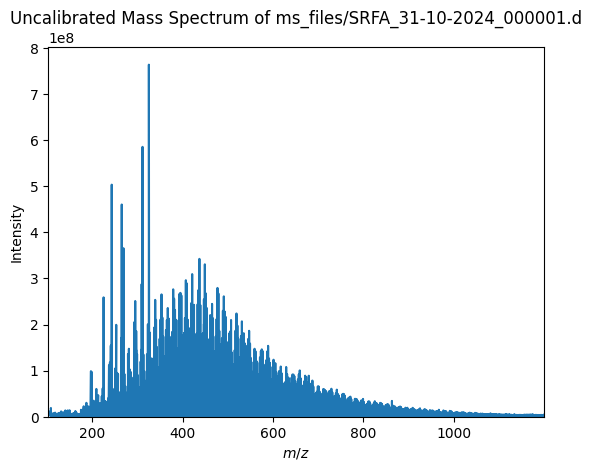

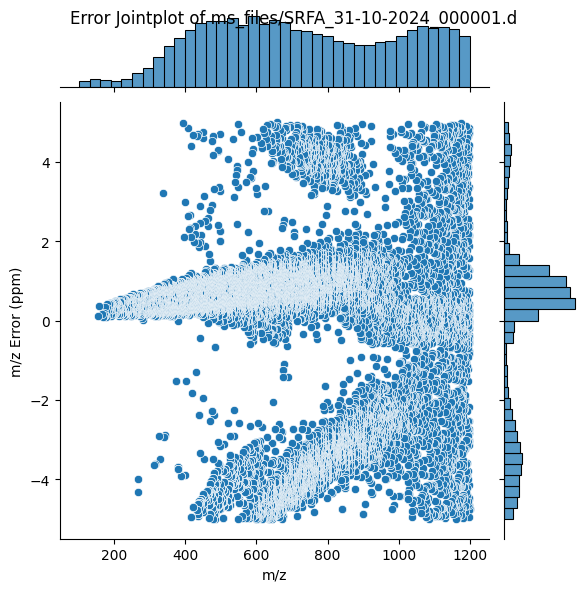

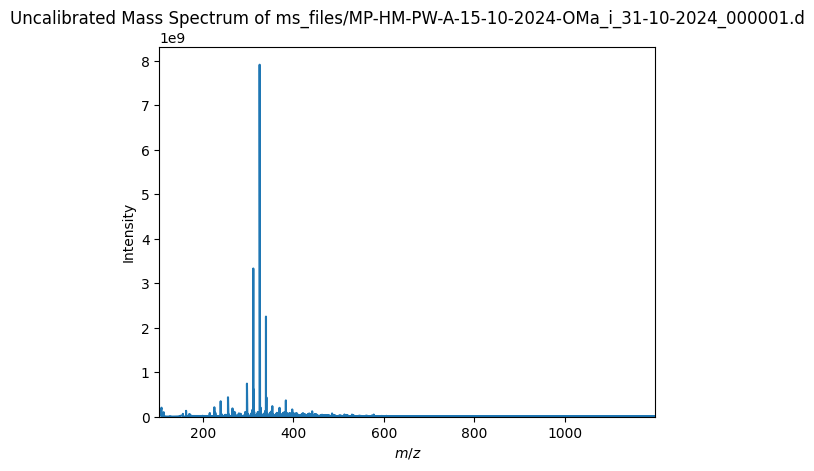

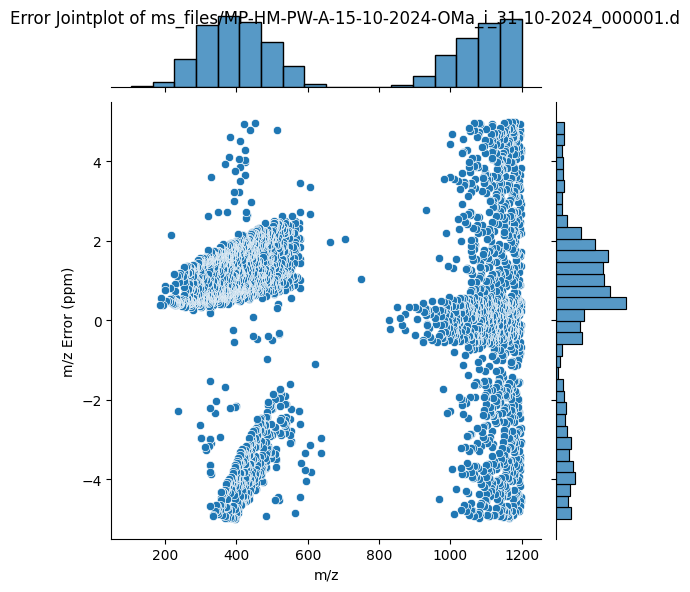

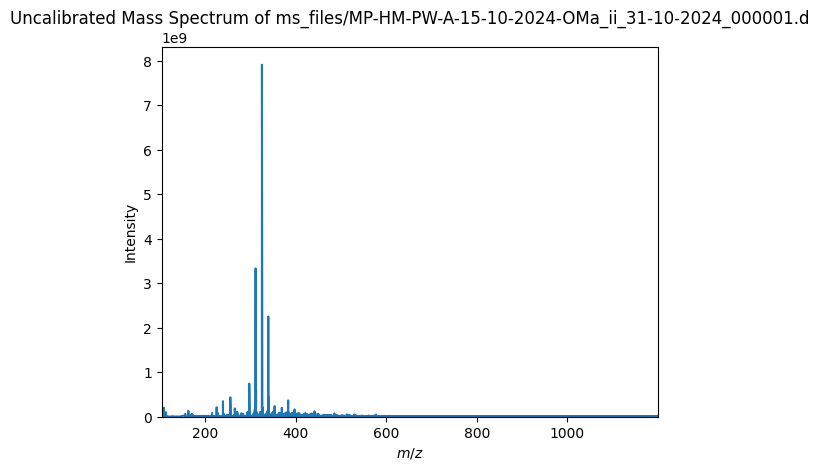

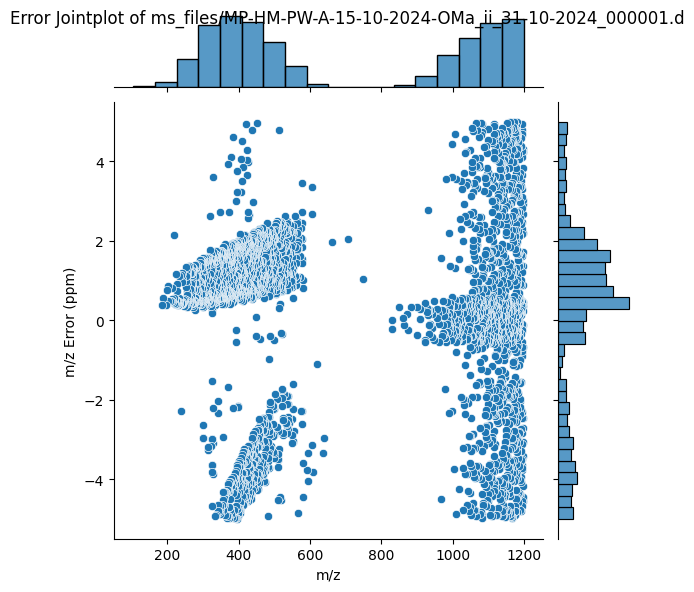

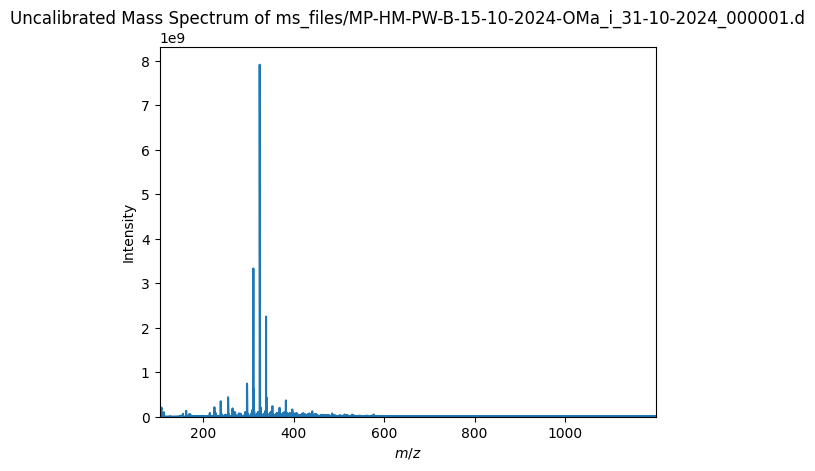

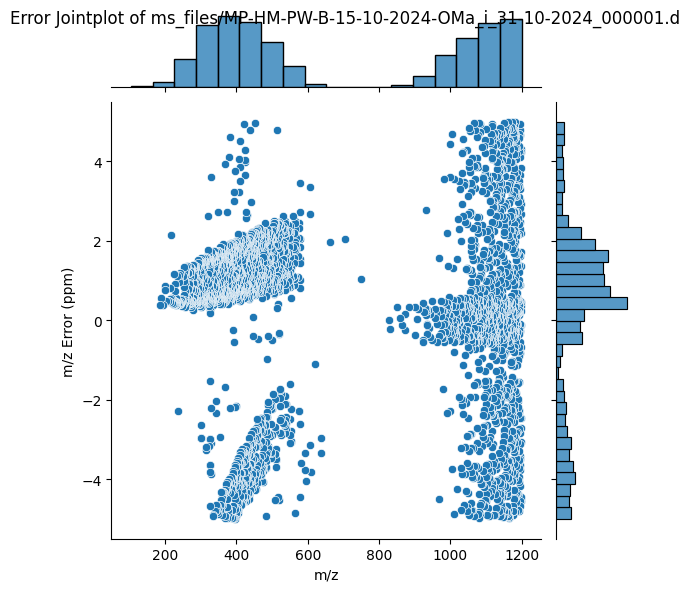

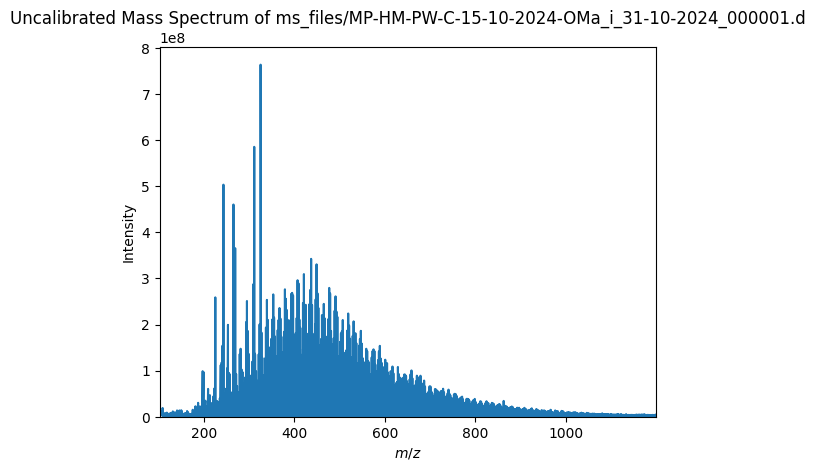

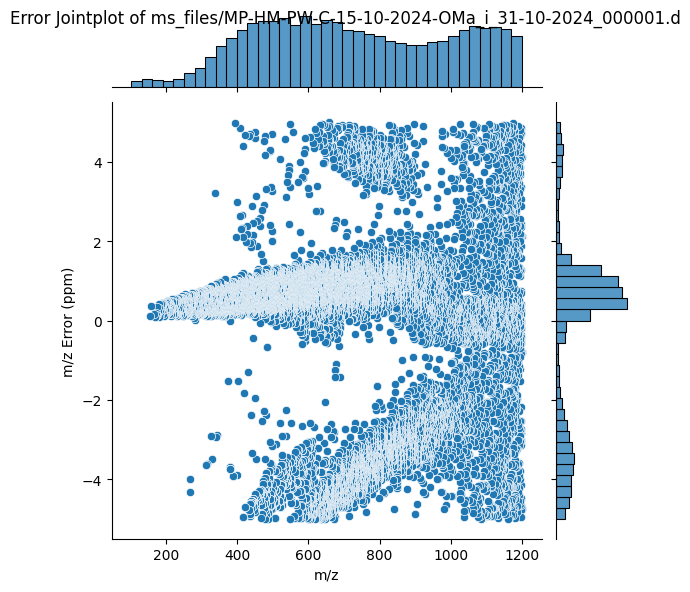

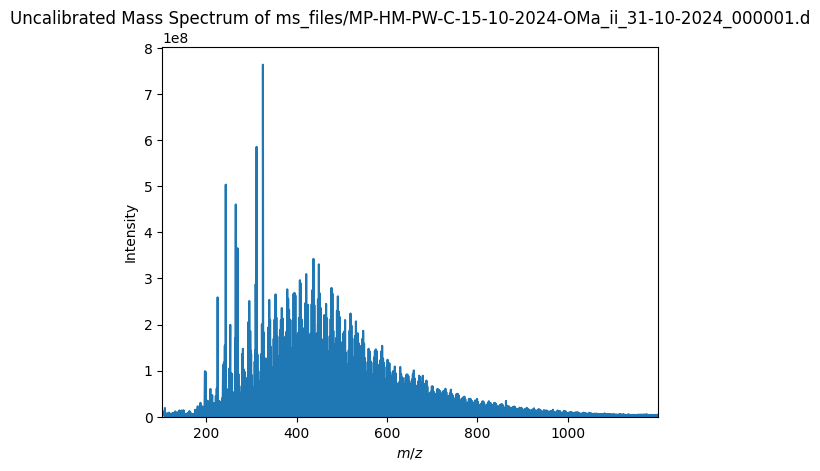

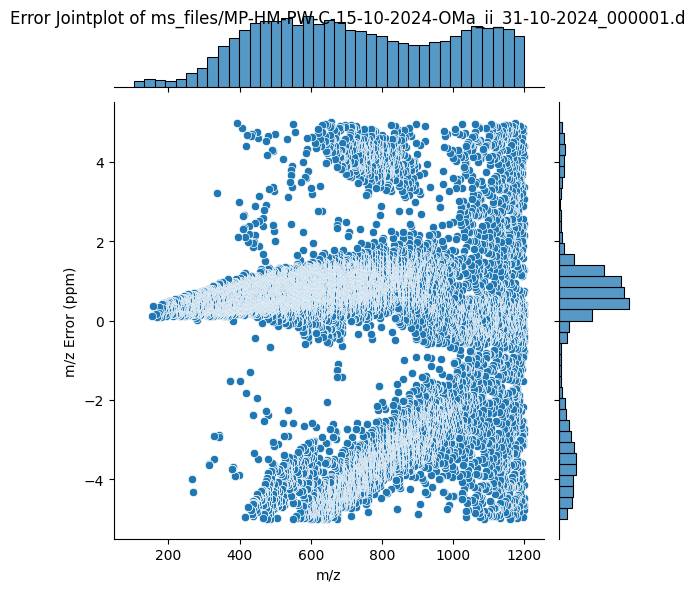

In [36]:
# Main processing loop

spectra_dfs = {}

# Process the spectra date by date so as to have the correct intrinsic error
for date in dates:
    samples_csv_df_bydate = samples_csv_df[samples_csv_df['date']==date]
    blanks_csv_df_bydate = blanks_csv_df[blanks_csv_df['date']==date]

    unique_blanks = np.unique(blanks_csv_df['associated_name'])

    # Load the right value for the calibration ppm error threshold
    if type(calib_ppm_error_threshold)==dict:
        calib_ppm_error_threshold_bydate = calib_ppm_error_threshold[date]
    else: calib_ppm_error_threshold_bydate = calib_ppm_error_threshold

    # Process the spectra sharing the same blanks together
    for blank in unique_blanks:
        associated_blank = give_associated_blank_name(blank)
        samples_csv_df_bydate_byblk = samples_csv_df_bydate[samples_csv_df_bydate['associated_blank']==associated_blank]
        blanks_csv_df_bydate_byblk = blanks_csv_df_bydate[blanks_csv_df_bydate['associated_name']==blank]

        # Process the spectra
        spectra_dfs, logs_txt = process_spectra(samples_csv_df_bydate_byblk['file_name'].to_numpy(),blanks_csv_df_bydate_byblk,spectra_dfs,calib_ppm_error_threshold_bydate,logs=logs,logs_txt=logs_txt)

In [37]:
if logs:
    with open(f'{logs_folder}/{logs_title}', 'w') as f:
        f.write(logs_txt)

In [38]:
keys = list(spectra_dfs.keys())
keys[0]

'ms_files/SRFA_31-10-2024'

In [39]:
spectra_dfs

{'ms_files/SRFA_31-10-2024':        Index          m/z  Calibrated m/z  Calculated m/z   Peak Height  \
 0         13  1199.216571     1199.216571     1199.222263  2.826174e+06   
 1         26  1198.706044     1198.706044     1198.701119  2.691131e+06   
 2         26  1198.706044     1198.706044     1198.706992  2.691131e+06   
 3         26  1198.706044     1198.706044     1198.703483  2.691131e+06   
 4         32  1198.215524     1198.215524     1198.218908  2.388712e+06   
 ...      ...          ...             ...             ...           ...   
 28269  23142   103.668571      103.668571             NaN  2.265992e+06   
 28270  23143   103.058415      103.058415             NaN  5.943959e+06   
 28271  23144   103.008815      103.008815             NaN  2.673565e+06   
 28272  23145   102.996657      102.996657             NaN  2.586394e+06   
 28273  23146   102.336871      102.336871             NaN  2.632900e+06   
 
        Resolving Power       S/N  Ion Charge  m/z Error (

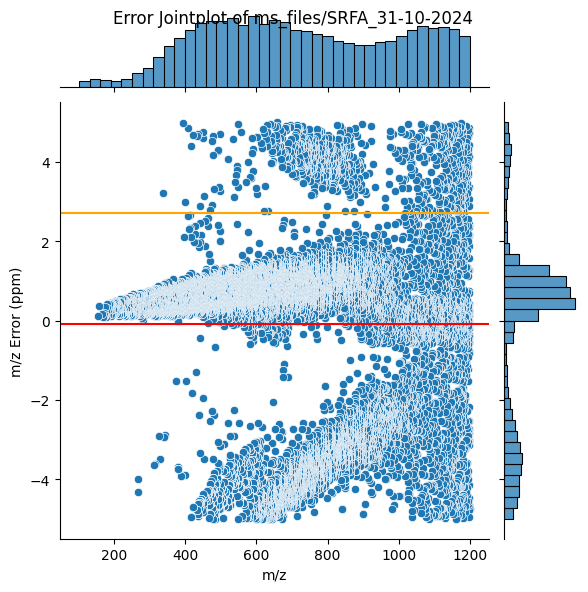

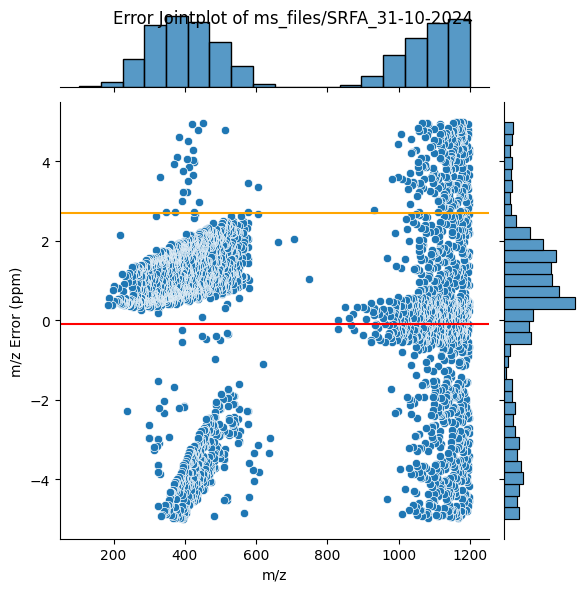

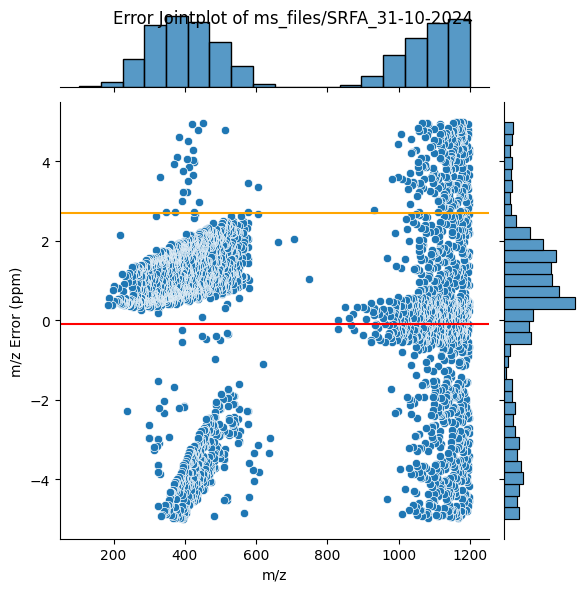

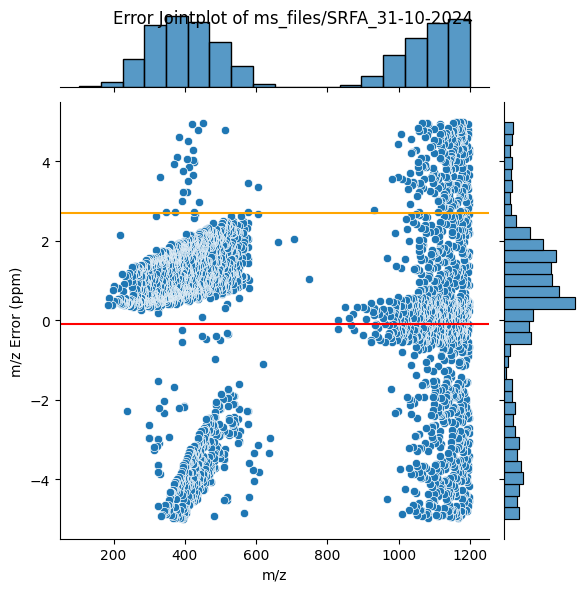

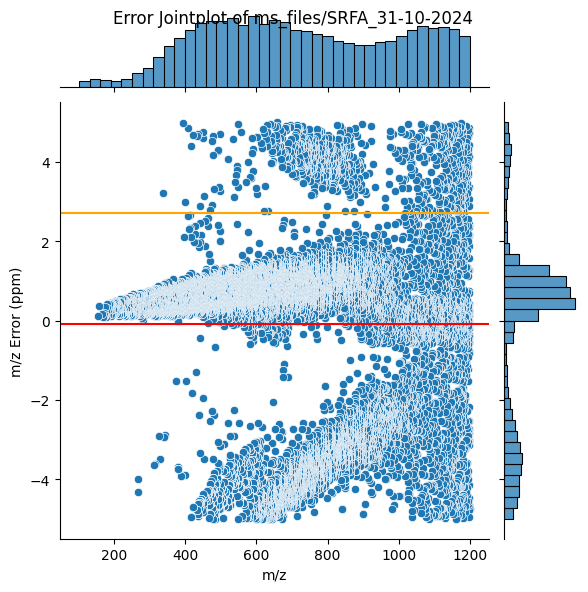

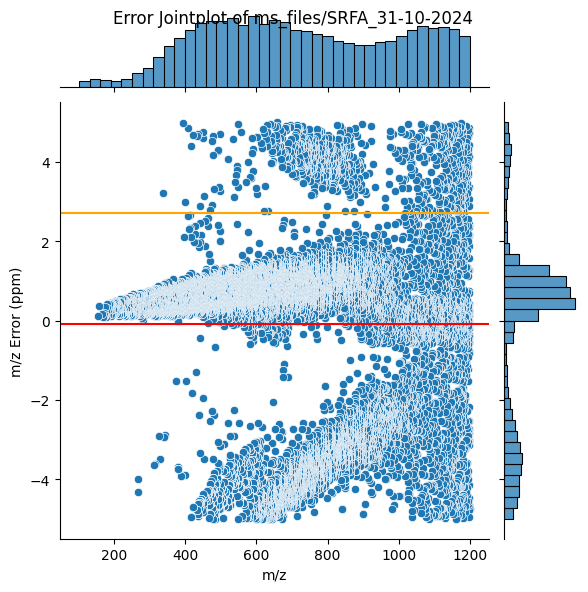

In [40]:
# Study intrinsic error distribution:
if not calibration:
    save_intr_err_cal_fig = 0

    date_no = 0 
    samples_csv_df_bydate = samples_csv_df[samples_csv_df['date']==samples_csv_df['date'].to_numpy()[date_no]]

    for name in samples_csv_df['sample_name']:

        keys_idx = 0
        keys = list(spectra_dfs.keys())
        jointplot = sns.jointplot(x='m/z', y='m/z Error (ppm)', data = spectra_dfs[f'{spectra_folder}/{name}'])
        
        jointplot.fig.suptitle(f"Error Jointplot of {keys[keys_idx]}")
        plt.axhline(-.1,c='r')
        plt.axhline(2.7,c='orange')

        if save_intr_err_cal_fig:
            intr_err_path = 'int_err_study_figures'
            if not os.path.exists(csv_folder): os.mkdir(csv_folder)
            jointplot.fig.savefig(f'{intr_err_path}/int_err_for_{keys[keys_idx]}.png',dpi=600, facecolor = '#fff', bbox_inches='tight')

In [41]:
a = 1
b = 2
d = 5
def c(b):
    if a: d = 6
    b += 2

logs=1
logs_txt='nvjsvbnslkjvb\n'

In [42]:
def process_spectra(**kwargs):
    '''
    Batch process raw mass spectra into more easily accessible CSV files.

    Have a look at https://github.com/Kzra/pykrev/tree/master/docs/corems_with_pykrev by Dr Ezra Kitson for a tutorial example.
    '''
    # logs = kwargs.get('logs', False)
    if logs:
        logs_txt = kwargs.get('logs_txt', '')
        logs_txt += f'FOR SAMPLE 1: TOTAL ASSIG\n'

    return logs_txt

In [43]:
for i in range(4):
    logs_txt = process_spectra(logs_txt=logs_txt)

In [44]:
logs_txt

'nvjsvbnslkjvb\nFOR SAMPLE 1: TOTAL ASSIG\nFOR SAMPLE 1: TOTAL ASSIG\nFOR SAMPLE 1: TOTAL ASSIG\nFOR SAMPLE 1: TOTAL ASSIG\n'